In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [14]:
def Runge_Kutta4(f,y_0,t):
    """
    f es la función de dy/dt = f(y,t)
    y_0 es una initial guess
    t es el linspace de tiempo (o variable independiente, como querás)
    """
    
    h = t[1] - t[0]
    y = np.zeros_like(t)
    y[0] = y_0
    
    for i in range(1,len(t)):
        k1 = h*f(y[i-1],t[i-1])
        k2 = h*f(t[i-1]+h/2,y[i-1] +k1/2)
        k3 = h* f(t[i-1]+h/2, y[i-1] + k2/2)
        k4 = h* f(t[i-1]+h,y +k3)
        
        y[i] = y[i-1] + (k1+2*k2+2*k3+k4)/6
    
    return y

In [15]:
def Adams_Bashforth_Moulton(f,x,y_sol_proposed):
    """
    Básicamente, lo que hace esta maricada es que coges la función de tu ecuación deferencial dy/dx = f(x,y) y, 
    luego de haberla resuelto con método de Runge-Kutta, se lo metes a esta función por medio de y_sol_proposed y
    esta madre te lo corrige para que quede Gucci.
    """
    
    h = x[1] - x[0]
    
    y = y_sol_proposed.copy() #Una copia de la solución (de cagada) que te dejó RK
    yc = y.copy() #Otra copia (la que vamos a modificar ;D)/corregir.
    
    for i in range(2,len(x)):
        #Esta partecita de aquí lo que hace es hacer una una predicción del siguiente valor
        #Teniendo en cuenta las soluciones anteriores, esto gracias a que se tiene la solución (de cagada) que te dejó el método de 
        # aproximación (RK4354354, por ejemplo). Esto es la parte Bashforth
        
        y[i] = y[i-1] + 0.5*h*(3*f(x[i-1],y[i-1])-f(x[i-2],y[i-2]))
        yc[i] = y[i]
        
        """
        Lo que sigue es la parte Moulton, que se trata de la corrección de la predicción
        que hizo el algoritmo Bashforth para la solución (de mierda) que te entregó RK. Hay de varios órdenes (en este caso 2) en Wiki están los demás-
        """
        
        yc[i] = yc[i-1] + h*( 5*f(x[i],y[i]) + 8*f(x[i-1],y[i-1]) - f(x[i-2],y[i-2]) )/12
        
        return y,yc # Te devuelve la predicción y la corrección (respectivamente)
        

In [16]:
"""
Bueno voy a leer lo del paso adaptativo. 4:41 a.m.
"""

'\nBueno voy a leer lo del paso adaptativo. 4:41 a.m.\n'

In [203]:
"""
Espero pegar la predicción, pero teniendo en cuenta que el profesor puso un RK45 en el tablero como spolier del parcial,
me adelantaré un poquito y voy a implementar una versión de éste algoritmo que encontré en un paper de por ahí.
"""

tolerance = 1e-6

def RK_Fehlberg(f, r, t, step):
    """
    Acá está la estructura de las constantes del método Runge-Kutta-Fehlberg o RK45. No sé si es algún episodio epifánico 
    de la madrugada o el café pero... ¿Por qué en las clases se le hace un unpacking al array de las pendientes instantáneas
    pudiendo colocar el array y ya...? 
    """
    R1 = r
    K1 = step * f(R1, t)
    
    R2 = r + K1/4
    K2 = step * f(R2, t + step/4)
    
    R3 = r + (3/32) * K1 + (9/32) * K2
    K3 = step * f(R3, t + (3 * step)/8) 
    
    R4 = r + (1932/2197) * K1 - (7200/2197) * K2 + (7296/2197) * K3
    K4 = step * f(R4, t + (12 * step)/13)
    
    R5 = r + (439/216) * K1 - 8 * K2 + (3680/513) * K3 - (845/4104) * K4
    K5 = step * f(R5, t + step)
    
    R6 = r - (8/27) * K1 + 2 * K2 - (3544/2565) * K3 + (1859/4104) * K4 - (11/40) * K5
    K6 = step * f(R6, t + step/2)
    
    r_first = r + (25/216) * K1 + (1408/2565) * K3 + (2197/4104) * K4 - (1/5) * K5
    r_second = r + (16/135) * K1 + (6656/12825) * K3 + (28561/56430) * K4 - (9/50) * K5 + (2/55) * K6
    
    R = np.linalg.norm(r_first - r_second)/step
    delta = 0.84 * (tolerance/R)**(1/4)
    
    if R <= tolerance:
        r = r_first
        step = delta * step
        passed = True
    elif R > tolerance:
        step = delta * step
        passed = False
    
    return r, step, passed

In [204]:
def AdaptativeRK45(f, r0, t):
    step = t[1] - t[0]
    ti, tf = t[0], t[-1]
    
    r = r0
    vectors = r
    time = np.array([ti])
    steps = np.array([step])
    
    while ti < tf:
        r_, step_, passed = RK_Fehlberg(f, r, ti, step)
        step = step_
        
        if passed == True:
                vectors = np.vstack((vectors, r_))
                r = r_
                step = step_
        
        elif passed == False:
            while passed == False:
                rtry, steptry, passedtry = RK_Fehlberg(f, r, ti, step)
                passed = passedtry
                r_ = rtry
                step_ = steptry
            
            if passed == True:
                vectors = np.vstack((vectors, r_))
                r = r_
                step = step_

        ti = ti + step
        
        time = np.append(time, ti)
        steps = np.append(steps, step)
    
    return time, vectors, steps

In [205]:
def System(r,t,mu=1.3):
    
    x,vx = r
    
    dxdt = vx
    dvxdt = mu*(1-x**2)*vx - x
    
    return np.array([dxdt,dvxdt])

t = np.linspace(0,20,100)
r0 = np.array([0.5,0.])

In [206]:
t1,x1,h1 = AdaptativeRK45(System,r0,t)
sol = odeint(System, r0, t, args=(1.3,))

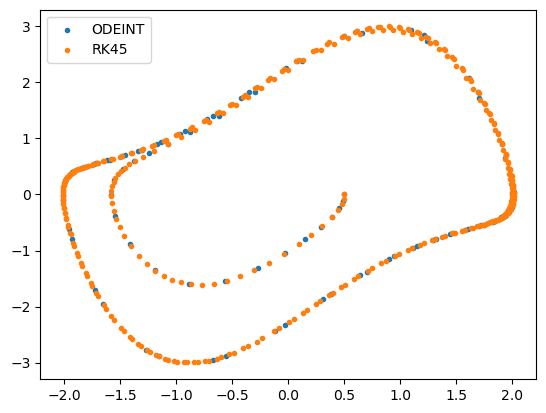

In [207]:
plt.scatter(sol[:,0],sol[:,1],marker='.', label = "ODEINT")
plt.scatter(x1[:,0],x1[:,1],marker='.', label = "RK45")
plt.legend()